# Inverse Compton Scattering

DarkHistory comes with the module [`darkhistory.electrons.ics`](https://hongwanliu.github.io/DarkHistory/html/_autosummary/darkhistory/electrons/darkhistory.electrons.ics.html) to compute the inverse Compton scattering (ICS) scattered photon spectrum in the Thomson limit and in the relativistic limit, as well as the scattered electron energy-loss spectrum, which can be used to obtain the scattered electron spectrum. See our paper for more details and definitions for these terms. 

All of our calculations assume ICS off a **blackbody spectrum**. 

## Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline


In [26]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import numpy as np

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_spectrum import thomson_spec
from darkhistory.electrons.ics.ics_spectrum import rel_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf


## Computing the ICS Spectra

Before we begin, the user should note that DarkHistory provides the transfer functions for inverse Compton scattering off the CMB for immediate use with the default electron and photon binning for spectra found in [`config`](https://hongwanliu.github.io/DarkHistory/html/_autosummary/config.html). The user will not have to worry about computing ICS spectra separately if this is the only way in which the ICS results are used. 

However, some users may want to specifically use our ICS code to compute their own spectra, with their own binning in electron and photon energies. This example will illustrate how to do that. 

### Scattered Photon Spectrum - Thomson Regime

First, we'll compute the scattered photon spectrum in the Thomson regime.  ICS occurs in the Thomson regime when

$$ \frac{4\epsilon \gamma_e}{m_e} \ll 1 \,,$$

where $\epsilon$ is the initial energy of the photon, $\gamma_e$ is the Lorentz boost of the injected electron, and $m_e$ is the incoming mass. For the range of redshifts we consider in DarkHistory $1+z < 3000$, $\gamma_e \lesssim 10^4$ can be considered to lie well within the Thomson regime. Note that the Thomson and relativistic regime (where $\gamma_e \gg 1$) have a large overlap, and calculations in both regimes should yield almost identical results.

The relevant function that we will call is [`ics.thomson_spec`](https://hongwanliu.github.io/DarkHistory/html/_autosummary/darkhistory/electrons/ics/ics_spectrum/darkhistory.electrons.ics.ics_spectrum.thomson_spec.html). This function takes an abscissa for the kinetic energy of electrons, the energy of photons, and the temperature at which we want the spectrum.

The successful calculation of the spectrum looks like this:

```
Initializing...
***** Computing Spectra by Expansion in beta ...... Complete! *****
***** Computing Spectra by Analytic Series... *****
Series 1/12...
Series 2/12...
Series 3/12...
Series 4/12...
Series 5/12...
Series 6/12...
Series 7/12...
Series 8/12...
Series 9/12...
Series 10/12...
Series 11/12...
Series 12/12...
***** Analytic Series Computation Complete! *****
########### Spectrum computed! ###########
```

In [18]:
nEe = 500
nEp = 500

Emax = 1.1e10
Emin = 0.9e-8

dlnEp = np.log(Emax/Emin)/nEp
lowengEp = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax/Emin)/nEe
lowengEe = Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)

ics_thomson_tf = thomson_spec(lowengEe, lowengEp, 0.25)

Initializing...
***** Computing Spectra by Expansion in beta ...... Complete! *****
***** Computing Spectra by Analytic Series... *****
Series 1/12...
Series 2/12...
Series 3/12...
Series 4/12...
Series 5/12...
Series 6/12...
Series 7/12...
Series 8/12...
Series 9/12...
Series 10/12...
Series 11/12...
Series 12/12...
***** Analytic Series Computation Complete! *****
########### Spectrum computed! ###########


Let's make a plot of the spectrum produced. The matrix corresponding to the transfer function can be accessed directly by the function [`grid_vals()`](https://hongwanliu.github.io/DarkHistory/html/_autosummary/darkhistory/spec/transferfunction/darkhistory.spec.transferfunction.TransFuncAtRedshift.html), and is indexed by (``eleceng``, ``photeng``). 

[1e-08, 100000000.0, 1e-08, 1e+16]

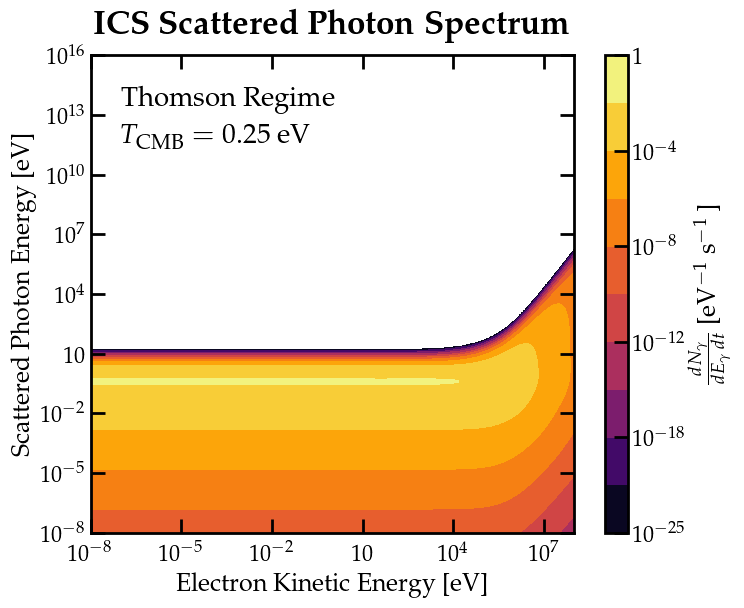

In [57]:
plt.figure(figsize=(7.8, 6.2))

plt.contourf(
    lowengEe, lowengEp, np.transpose(ics_thomson_tf.grid_vals), 
    levels=10.**np.array([-25, -22, -18, -15, -12, -10, -8, -6, -4, -2, 0]), cmap = 'inferno',
    norm = LogNorm()
            )

plt.colorbar(label=r'$\frac{dN_\gamma}{dE_\gamma \, dt}$ [eV$^{-1}$ s$^{-1}$ ]')
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\textbf{ICS Scattered Photon Spectrum}')
plt.xlabel('Electron Kinetic Energy [eV]')
plt.ylabel('Scattered Photon Energy [eV]')

plt.text(1e-7, 3e13, 'Thomson Regime', fontsize=20)
plt.text(1e-7, 2e11, r'$T_{\mathrm{CMB}} = $ 0.25 eV', fontsize=20)

plt.axis([1e-8, 1e8, 1e-8, 1e16])

# plt.savefig('/Users/hongwan/Dropbox (MIT)/Photon Deposition/Draft/plots/ics_thomson_scattered_phot_spec.pdf')

### Scattered Photon Spectrum - Relativistic Regime

We can also get the spectrum in the relativistic regime, i.e. when $\gamma_e \gg 1$. In DarkHistory, the transition occurs by default at $\gamma_e = 20$. The function that does this is [`ics.rel_spec`](https://hongwanliu.github.io/DarkHistory/html/_autosummary/darkhistory/electrons/ics/ics_spectrum/darkhistory.electrons.ics.ics_spectrum.rel_spec.html). Note that this function takes the *total electron energy* as input, rather than the kinetic energy. 

`rel_spec` also has a flag `inf_upp_bound`, which determines the level of approximation to apply to the spectrum. If `inf_upp_bound` is True, only downscattering of electrons is included among other approximations, and returns a spectrum that is unreliable below a final photon energy of $E_1 < T_\text{CMB}$. However, this part of the spectrum accounts for a minute portion of the total energy deposited into photons, and the produced transfer function can be reused for different redshifts. 

With `inf_upp_bound` set to False, upscattering of electrons is included, and the spectrum is accurate up to $\mathcal{O}(1/\gamma^2)$ terms. 

The successful execution of this calculation will produce the following printout:

```
Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
```

In [27]:
Emax_rel = 1e20
Emin_rel = 1e-8
nEe = 500
nEp  = 500

dlnEp = np.log(Emax_rel/Emin_rel)/nEp
lowengEp_rel = Emin_rel*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax_rel/Emin_rel)/nEe
lowengEe_rel = Emin_rel*np.exp((np.arange(nEe)+0.5)*dlnEe)

ics_rel_tf = rel_spec(phys.me+lowengEe_rel, lowengEp_rel, 0.25, inf_upp_bound=False)

Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!


And now we'll plot the spectrum. Observe that the relativistic spectrum at the low energy end of this plot is exactly the same as the Thomson spectrum at the same energy: we have chosen parameters such that both the Thomson and relativistic approximations are valid in this region.

[100000000.0, 100000000000000.0, 1e-08, 1e+16]

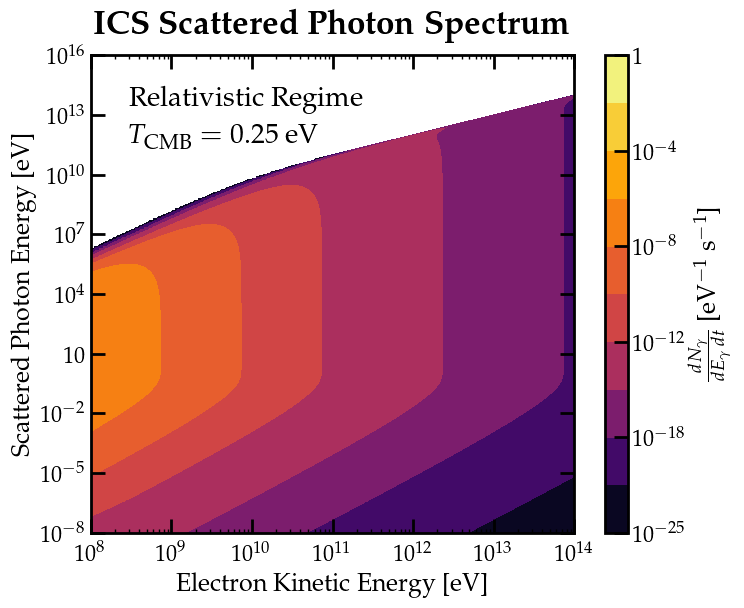

In [58]:
plt.figure(figsize=(7.8, 6.2))

plt.contourf(
    phys.me+lowengEe_rel, lowengEp_rel, np.transpose(ics_rel_tf.grid_vals), 
    levels=10.**np.array([-25, -22, -18,-15, -12, -10, -8, -6, -4, -2, 0]), cmap = 'inferno',
    norm = LogNorm()
            )

plt.colorbar(label=r'$\frac{dN_\gamma}{dE_\gamma \, dt}$ [eV$^{-1}$ s$^{-1}$]')
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\textbf{ICS Scattered Photon Spectrum}')
plt.xlabel('Electron Kinetic Energy [eV]')
plt.ylabel('Scattered Photon Energy [eV]')

plt.text(3e8, 3e13, 'Relativistic Regime', fontsize=20)
plt.text(3e8, 2e11, r'$T_{\mathrm{CMB}} = $ 0.25 eV', fontsize=20)

plt.axis([1e8, 1e14, 1e-8, 1e16])

# plt.savefig('/Users/hongwan/Dropbox (MIT)/Photon Deposition/Draft/plots/ics_rel_scattered_phot_spec.pdf')

### Scattered Photon Spectrum - All Regimes

The user may simply use [`ics.ics_spec`](https://hongwanliu.github.io/DarkHistory/html/_autosummary/darkhistory/electrons/ics/ics_spectrum/darkhistory.electrons.ics.ics_spectrum.ics_spec.html) to switch between the two regimes automatically. There are two ways to use this function: either by passing it the electron kinetic energy and photon energy abscissae, or by passing it transfer functions, over which a very fast interpolation can be done to get the spectrum at other temperatures. 

Here, let's use `ics.ics_spec` to calculate the spectrum from scratch. 

In [76]:
Emax = 1e14
Emin = 1e-8
nEe = 500
nEp  = 500

dlnEp = np.log(Emax/Emin)/nEp
Ep = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax/Emin)/nEe
Ee = Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)

ics_tf = ics_spec(Ee, Ep, 0.25, inf_upp_bound=False)

Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
Initializing...
***** Computing Spectra by Expansion in beta ...... Complete! *****
***** Computing Spectra by Analytic Series... *****
Series 1/12...
Series 2/12...
Series 3/12...
Series 4/12...
Series 5/12...
Series 6/12...
Series 7/12...
Series 8/12...
Series 9/12...
Series 10/12...
Series 11/12...
Series 12/12...
***** Analytic Series Computation Complete! *****
########### Spectrum computed! ###########


And now let's make the plot! Observe the smooth transition at $\gamma_e = 20 \sim $ 10 MeV in electron energy. We've  demonstrated a way of obtaining the ICS scattering spectrum of electrons off the CMB over a wide range of regimes. 

[1e-08, 100000000000000.0, 1e-08, 1e+16]

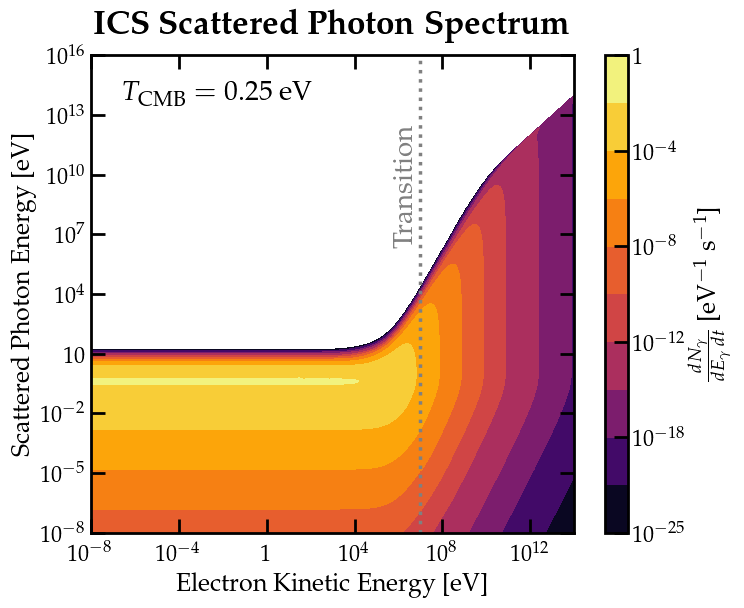

In [78]:
plt.figure(figsize=(7.8, 6.2))

plt.contourf(
    Ee, Ep, np.transpose(ics_tf.grid_vals), 
    levels=10.**np.array([-25, -22, -18,-15, -12, -10, -8, -6, -4, -2, 0]), cmap = 'inferno',
    norm = LogNorm()
            )

plt.axvline(19*phys.me, color='gray', linestyle=':')

plt.colorbar(label=r'$\frac{dN_\gamma}{dE_\gamma \, dt}$ [eV$^{-1}$ s$^{-1}$]')
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\textbf{ICS Scattered Photon Spectrum}')
plt.xlabel('Electron Kinetic Energy [eV]')
plt.ylabel('Scattered Photon Energy [eV]')

plt.text(3e-7, 3e13, r'$T_{\mathrm{CMB}} = $ 0.25 eV', fontsize=20)
plt.text(5e5, 3e11, 'Transition', fontsize=20, rotation=90, color='gray')

plt.axis([1e-8, 1e14, 1e-8, 1e16])

# plt.savefig('/Users/hongwan/Dropbox (MIT)/Photon Deposition/Draft/plots/ics_rel_scattered_phot_spec.pdf')

The other way to use `ics_spec` is to pass it two transfer functions, one corresponding to a Thomson regime transfer function, the other a relativistic regime transfer function, both evaluated at some reference temperature $T_\text{ref}$. We can now interpolate over these two transfer functions to obtain the spectrum at different temperatures. First, we need to produce the relativistic regime transfer function with `inf_upp_bound` set to True. This is the correct setting for using the transfer function for interpolation.

In [82]:
Emax_rel = 1e20
Emin_rel = 1e-8
nEe = 500
nEp  = 500

dlnEp = np.log(Emax_rel/Emin_rel)/nEp
lowengEp_rel = Emin_rel*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax_rel/Emin_rel)/nEe
lowengEe_rel = Emin_rel*np.exp((np.arange(nEe)+0.5)*dlnEe)

ics_rel_interp_tf = rel_spec(phys.me+lowengEe_rel, lowengEp_rel, 0.25, inf_upp_bound=True)

Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!


And now here's the code to get the ICS spectrum at $T = 10^{-2}$ eV from the transfer functions that we have already evaluated at $T = 0.25 $ eV. It's important that the transfer functions are evaluated over a large enough range of electron and photon energies. 

In [90]:
Emax = 1e20
Emin = 1e-5
nEe = 500
nEp  = 500

dlnEp = np.log(Emax/Emin)/nEp
Ep = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax/Emin)/nEe
Ee = Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)

# The function arguments are 
#(electron kinetic energy, photon energy, temperature, Thomson transfer function,
# relativistic transfer function, reference temperature)

ics_interp_tf = ics_spec(Ee, Ep, 1e-2, thomson_tf = ics_thomson_tf, rel_tf = ics_rel_interp_tf, T_ref = 0.25)

And the plot of the spectra at $T = 10^{-2}$ eV. Notice the poor transition at the low end of the spectrum. This however does not affect the bulk of the spectrum (as measured in energy). 

[1e-05, 100000000000000.0, 1e-05, 1e+16]

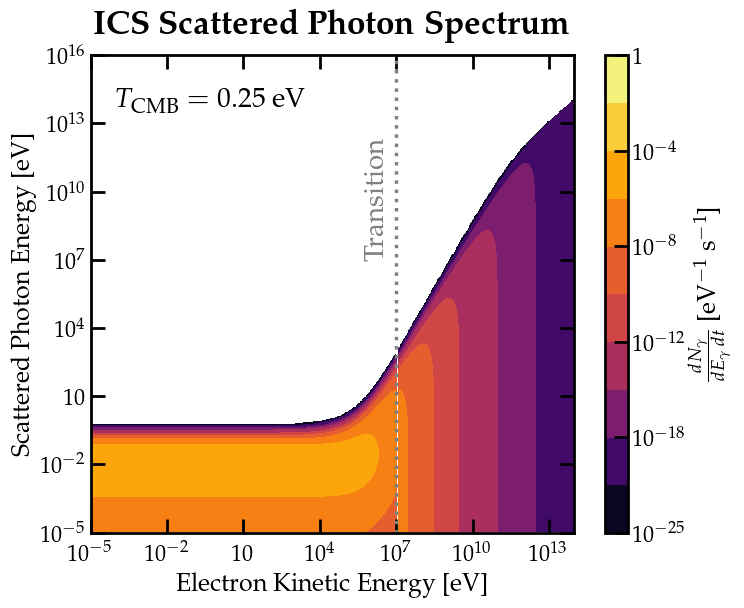

In [95]:
plt.figure(figsize=(7.8, 6.2))

plt.contourf(
    Ee, Ep, np.transpose(ics_interp_tf.grid_vals), 
    levels=10.**np.array([-25, -22, -18,-15, -12, -10, -8, -6, -4, -2, 0]), cmap = 'inferno',
    norm = LogNorm()
            )

plt.axvline(19*phys.me, color='gray', linestyle=':')

plt.colorbar(label=r'$\frac{dN_\gamma}{dE_\gamma \, dt}$ [eV$^{-1}$ s$^{-1}$]')
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\textbf{ICS Scattered Photon Spectrum}')
plt.xlabel('Electron Kinetic Energy [eV]')
plt.ylabel('Scattered Photon Energy [eV]')

plt.text(1e-4, 3e13, r'$T_{\mathrm{CMB}} = $ 0.25 eV', fontsize=20)
plt.text(5e5, 3e11, 'Transition', fontsize=20, rotation=90, color='gray')

plt.axis([1e-5, 1e14, 1e-5, 1e16])

# plt.savefig('/Users/hongwan/Dropbox (MIT)/Photon Deposition/Draft/plots/ics_rel_scattered_phot_spec.pdf')

### Mean Electron Energy Loss Spectrum

We can also compute the scattered electron net energy loss spectrum in a similar fashion. The function of interest is [`ics.ics_engloss_spectrum.engloss_spec`](https://hongwanliu.github.io/DarkHistory/html/_autosummary/darkhistory/electrons/ics/darkhistory.electrons.ics.ics_engloss_spectrum.html), and works in a very similar way, although the calculation is more complicated. A successful execution will print the following:

```
Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
Computing integrals 1/6...
Computing integrals 2/6...
Computing integrals 3/6...
Computing integrals 4/6...
Computing integrals 5/6...
Computing integrals 6/6...
Integrals computed!
Computation by expansion in beta complete!
Computing energy loss spectrum by analytic series...
Computing upscattering loss spectra...
Computing series 1/7...
Computing series 2/7...
Computing series 3/7...
Computing series 4/7...
Computing series 5/7...
Computing series 6/7...
Computing series 7/7...
Computing downscattering loss spectra...
Computing series 1/7...
Computing series 2/7...
Computing series 3/7...
Computing series 4/7...
Computing series 5/7...
Computing series 6/7...
Computing series 7/7...
Computing additional spectra for new spec_type...
Computing series 1/2...
Computing series 2/2...
Nonrelativistic energy loss spectrum computed!
```

In [99]:
Emax = 1e10
Emin = 1e-8
nEe = 500
nEp  = 500

dlnEp = np.log(Emax/Emin)/nEp
Ep = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax/Emin)/nEe
Ee = Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)

ics_engloss_tf = engloss_spec(Ee, Ep, 0.25, nonrel=True)

Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
Computing integrals 1/6...
Computing integrals 2/6...
Computing integrals 3/6...
Computing integrals 4/6...
Computing integrals 5/6...
Computing integrals 6/6...
Integrals computed!
Computation by expansion in beta complete!
Computing energy loss spectrum by analytic series...
Computing upscattering loss spectra...
Computing series 1/7...
Computing series 2/7...
Computing series 3/7...
Computing series 4/7...
Computing series 5/7...
Computing series 6/7...
Computing series 7/7...
Computing downscattering loss spectra...
Computing series 1/7...
Computing series 2/7...
Computing series 3/7...
Computing series 4/7...
Computing series 5/7...
Computing series 6/7...
Computing series 7/7...
Computing additional spectra for new spec_type...
Computing series 1/2...
Computing series 2/2...
Nonrelativistic energy loss spectrum computed!


And the plot:

[1e-08, 10000000000.0, 1e-08, 10000000000.0]

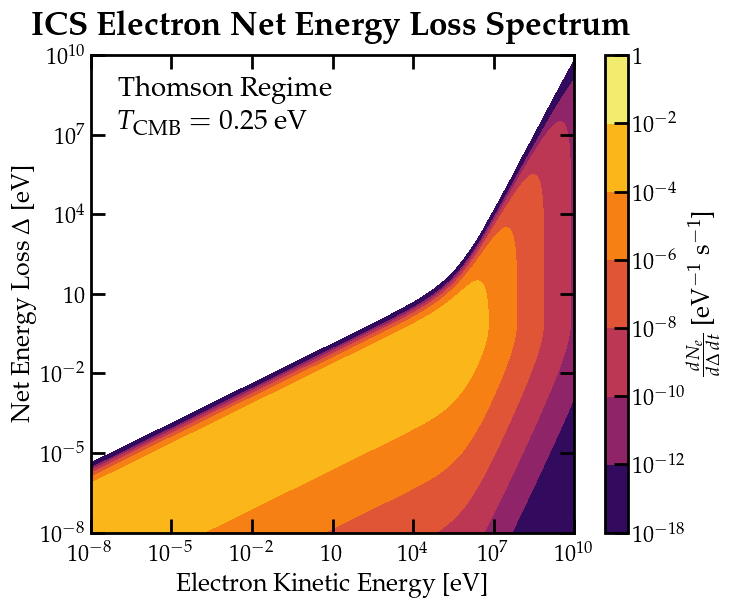

In [102]:
plt.figure(figsize=(7.8, 6.2))

plt.contourf(
    lowengEe_rel, lowengEp_rel, np.transpose(ics_engloss_tf.grid_vals), 
    levels=10.**np.array([-18, -12, -10, -8, -6, -4, -2, 0]), cmap = 'inferno',
    norm = LogNorm()
            )

plt.colorbar(label=r'$\frac{dN_e}{d\Delta \, dt}$ [eV$^{-1}$ s$^{-1}$]')
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\textbf{ICS Electron Net Energy Loss Spectrum}')
plt.xlabel(r'Electron Kinetic Energy [eV]')
plt.ylabel('Net Energy Loss $\Delta$ [eV]')

plt.text(1e-7, 3e8, 'Thomson Regime', fontsize=20)
plt.text(1e-7, 1e7, r'$T_{\mathrm{CMB}} = $ 0.25 eV', fontsize=20)

plt.axis([1e-8, 1e10, 1e-8, 1e10])

# plt.savefig('/Users/hongwan/Dropbox (MIT)/Photon Deposition/Draft/plots/ics_thomson_engloss_spec.pdf')

## Secondary Photon Spectrum

With these single-scattering transfer functions, we can now compute the secondary photon spectrum transfer function, which takes injected electrons through its complete cooling process, and produces a final secondary photon spectrum and low energy (sub 3 keV) electron spectrum. This is computed through the function `electrons.ics.ics_cooling.get_ics_cooling_tf()`. 

We will perform this computation by interpolation of a reference transfer function, evaluated at a temperature of $1000 T_{\mathrm{CMB},0}$. This is done in `DarkHistory` for speed. First, we define the abscissa (this is sufficient for redshifts from $1+z = 3000$ down to $1 + z = 4$):

In [9]:
Emax = 1e20
Emin = 1e-8
nEe = 500
nEp  = 500

dlnEp = np.log(Emax/Emin)/nEp
lowengEp_rel = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)        

dlnEe = np.log(Emax/Emin)/nEe
lowengEe_rel = Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)

Emax = 1e10
Emin = 1e-8
nEe = 500
nEp  = 500

dlnEp = np.log(Emax/Emin)/nEp
lowengEp_nonrel = Emin*np.exp((np.arange(nEp)+0.5)*dlnEp)  

dlnEe = np.log(Emax/Emin)/nEe
lowengEe_nonrel = Emin*np.exp((np.arange(nEe)+0.5)*dlnEe)


Next, we compute all of the reference scattered photon spectra (Thomson and relativistic) and the energy loss spectrum:

In [10]:
print('********* Thomson regime scattered photon spectrum *********')
ics_thomson_ref_tf = nonrel_spec(lowengEe_nonrel, lowengEp_nonrel, phys.TCMB(400))
print('********* Relativistic regime scattered photon spectrum *********')
ics_rel_ref_tf = rel_spec(lowengEe_rel, lowengEp_rel, phys.TCMB(400), inf_upp_bound=True)
print('********* Thomson regime energy loss spectrum *********')
engloss_ref_tf = engloss_spec(lowengEe_nonrel, lowengEp_nonrel, phys.TCMB(400), nonrel=True)

********* Thomson regime scattered photon spectrum *********
Initializing...
Computing spectra by an expansion in beta...
----> Computation by expansion in beta complete!
Computing spectra by analytic series...
*** Computing series 1/12...
*** Computing series 2/12...
*** Computing series 3/12...
*** Computing series 4/12...
*** Computing series 5/12...
*** Computing series 6/12...
*** Computing series 7/12...
*** Computing series 8/12...
*** Computing series 9/12...
*** Computing series 10/12...
*** Computing series 11/12...
*** Computing series 12/12...
----> Computation by analytic series complete!
Spectrum computed!
********* Relativistic regime scattered photon spectrum *********
Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
********* Thomson regime energy loss spectrum *********
Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
C

Now we compute the full ICS secondary photon spectrum, as well as the low energy secondary electron spectrum that are produced after the electrons cool completely. 

In [11]:
eleceng = 10**np.arange(2, 12, 0.025)
photeng = 10**np.arange(-4, 12, 0.025)


(ics_sec_phot_tf, ics_sec_elec_tf, cont_loss) = get_ics_cooling_tf(ics_thomson_ref_tf,
                                                     ics_rel_ref_tf,
                                                     engloss_ref_tf,
                                                     eleceng, photeng, 0.25/phys.TCMB(1))


/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


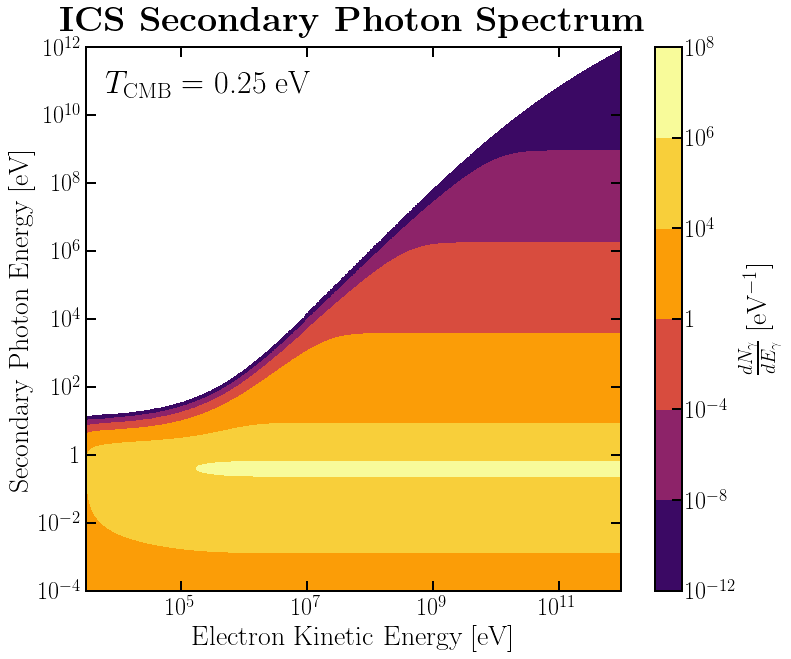

In [12]:
plt.figure(figsize=[12,10])

ax = plt.gca()

if ics_sec_phot_tf.spec_type == 'N':
    ics_sec_phot_tf.switch_spec_type()

plt.contourf(
    eleceng, photeng, np.transpose(ics_sec_phot_tf.grid_vals), 
    levels=10.**np.array([ -12, -8, -4, 0, 4, 6, 8]), cmap = 'inferno',
    norm = LogNorm()
            )

plt.text(6e3, 3e10, r'$T_{\mathrm{CMB}} = $ 0.25 eV', fontsize=32)

plt.colorbar(label=r'$\frac{dN_\gamma}{dE_\gamma}$ [eV$^{-1}$]')

plt.title(r'\textbf{ICS Secondary Photon Spectrum}')
plt.xlabel('Electron Kinetic Energy [eV]')
plt.ylabel('Secondary Photon Energy [eV]')

ax.set_xscale('log')
ax.set_yscale('log')

plt.axis([3e3, 1e12, 1e-4, 1e12])

plt.savefig('/Users/hongwan/Dropbox (MIT)/Photon Deposition/Draft/plots/ics_sec_phot_spec.pdf')

Now, scatter the initial photons through the full ICS transfer function. This is easily accomplished using the function `spec.spectools.scatter()`. This function takes in a transfer function, and applies it to an initial spectrum, producing the final spectrum after the scattering. The transfer function `spec_type` determines whether the transfer function acts as a map of number of particles to number of particles in each bin, or $dN/dE$ to $dN/dE$ in each bin. The `spec_type` of the input spectrum will be switched automatically based on this within the function, and the output has the same `spec_type` as the input. 

In [13]:
phot_spec_init = spectools.scatter(ics_phot_tf, elec_spec_init, new_eng=photeng)

NameError: name 'ics_phot_tf' is not defined